## Step 1 - Getting the point cloud and Computing Vietoris-Rips Complexes and Cohomology

Populating the interactive namespace from numpy and matplotlib


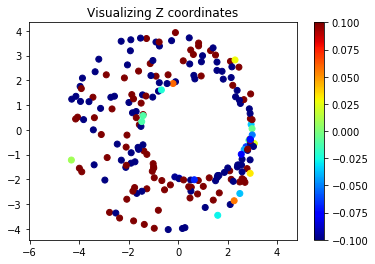

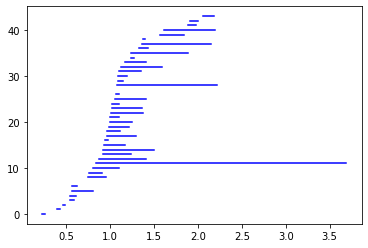

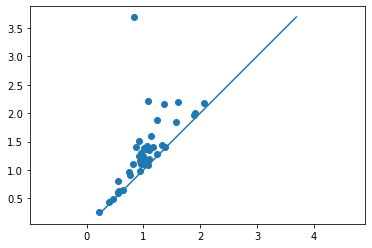

In [1]:
%pylab inline
import examples as eg
import numpy as np
from numpy import *
import dionysus

numpy.random.seed(seed=1234)

#points = eg.double_pinched_torus_example(n=200,a=.2,b=.2,c=2,d=.1)
points = eg.pinched_torus_example(n=200)
#Now we can plot the points using hue to show the Z coordinate
plt.scatter(points[:,0], points[:,1], c = points[:,2], cmap = 'jet')
plt.clim(-.1, .1)
plt.colorbar()
plt.axis('equal')
plt.title('Visualizing Z coordinates')
plt.figure()


#The examples.py generates data points in form of point clouds that can be analyzed using the imported dionysus module.
prime = 23 #choose the prime base for the coefficient field that we use to construct the persistence cohomology.

vr = dionysus.fill_rips(points, 2, 4.) #Vietoris-Rips complex up to dimension 2 and maximal distance 4
cp = dionysus.cohomology_persistence(vr, prime, True) #Create the persistent cohomology based on the chosen parameters.
dgms = dionysus.init_diagrams(cp, vr) #Calculate the persistent diagram using the designated coefficient field and complex.
dionysus.plot.plot_bars(dgms[1], show=True) 
dionysus.plot.plot_diagram(dgms[1], show=True) 
#dionysus.plot.plot_diagram(dgms[0], show=True) 
#Plot the barcode and diagrams using matplotlib incarnation within Dionysus2. This mechanism is different in Dionysus.

## Step 2 - Selecting the cocycle and visualization.

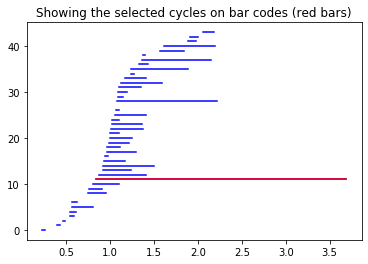

[0.8428179025650024, 3.6916277408599854]
[1.0797220468521118, 2.2150044441223145]


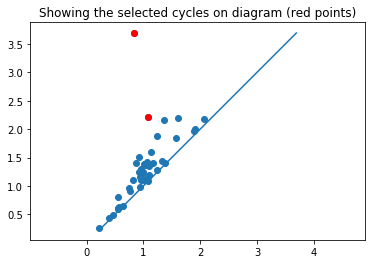

(0.842818,3.69163)


In [2]:
persistence_threshold = 1
bars = [bar for bar in dgms[1] if bar.death-bar.birth > persistence_threshold] 
#choosing cocycle that persist at least threshold=1.
cocycles = [cp.cocycle(bar.data) for bar in bars]
#plt is the matplotlib incarnation.

#Red highlight cocyles that persist more than threshold value on barcode, when more than one cocyles have persisted over threshold values, this plots the first one.
dionysus.plot.plot_bars(dgms[1], show=False)
plt.plot([[bar.birth,bar.death] for bar in dgms[1] if bar.death-bar.birth > persistence_threshold][0],[[x,x] for x,bar in enumerate(dgms[1]) if bar.death-bar.birth > persistence_threshold][0],'r')
plt.title('Showing the selected cycles on bar codes (red bars)')
plt.show()

#Red highlight ***ALL*** cocyles that persist more than threshold value on diagram.
dionysus.plot.plot_diagram(dgms[1], show=False)
Lt1 = [[point.birth,point.death] for point in dgms[1] if point.death-point.birth > persistence_threshold] 
for Lt3 in Lt1:
    print(Lt3)
    plt.plot(Lt3[0],Lt3[1],'ro')
plt.title('Showing the selected cycles on diagram (red points)')
plt.show()
chosen_cocycle= cocycles[0]
chosen_bar= bars[0]
#This is the same as choosing the maximal persistent cocycle when there is only one candidate cocycle.
#print(chosen_cocycle)
print(chosen_bar)

## Step 3 - Display the scatter points sampled from the manifold

In [3]:
pt = max(dgms[1], key = lambda pt: pt.death - pt.birth)
#print(pt)
chosen_cocycle = cp.cocycle(pt.data)
chosen_bar     = [bar for bar in dgms[1] if bar.death==pt.death and bar.birth==pt.birth]
chosen_bar     = chosen_bar[0]
#print(chosen_cocycle)
print(chosen_bar)
#fill_rips() computes Vietoris–Rips filtrations (up to a specified skeleton dimension and distance r).

(0.842818,3.69163)


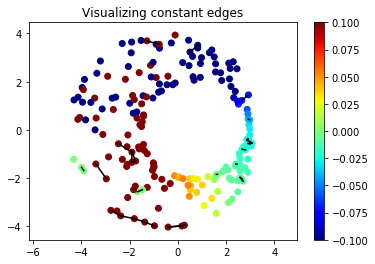

In [4]:
#If it is computed the smoothed coefficients can be used as initial condition for the optimization code
#hrluo: However, this optimization problem seems extremely sensitive to the initialization, the choice of L^2 smoothed coordinates does not seem to be 
vr_complex = dionysus.Filtration([s for s in vr if s.data <= max([bar.birth for bar in bars])])
coords = dionysus.smooth(vr_complex, chosen_cocycle, prime)
##To smooth the cocycle and convert it to the corresponding *circular coordinates*, we need to choose a complex, 
##in which we do the smoothing. 
##Here we select the complex in the filtration that exists at the midvalue of the persistence bar, (pt.death + pt.birth)/2:
##or the complex with the maximal birth
'''
https://mrzv.org/software/dionysus2/tutorial/cohomology.html
'''

toll = 1e-5
p,val = (chosen_bar,coords)

#Show the constant edges first.
edges_costant = []
thr = p.birth # i want to check all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
        #Only want edges in dim 1.
    elif s.data > thr:
        #print(s.data)
        #Only want those edges that exist when the chosen_bar is born.
        break
    if abs(val[s[0]]-val[s[1]]) <= toll:
        edges_costant.append([points[s[0],:],points[s[1],:]])
        
edges_costant = np.array(edges_costant)
plot(edges_costant.T[0,:],edges_costant.T[1,:], c='k')
#Now we can plot the points using hue to show the circular coordinate
plt.scatter(points[:,0], points[:,1], c = coords, cmap = 'jet')
plt.clim(-.1, .1)
plt.colorbar()
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()


## Step 4 - Second smoothing using a new cost function

In [5]:
import utils
l2_cocycle,f,bdry = utils.optimizer_inputs(vr, bars, chosen_cocycle, coords, prime)
l2_cocycle = l2_cocycle.reshape(-1, 1)

#np.zeros(l2_cocycle.shape[0])
#l2_cocycle.shape
#f-bdry*l2_cocycle

ZV = np.zeros(l2_cocycle.shape[0])
ZV = ZV.reshape(l2_cocycle.shape[0],1)
ZV.shape

(200, 1)

In [6]:
for a in np.array([0,1,2]):
    print(a)

0
1
2


In [7]:
def plotCir(res,keywrd='TensorFlow',ctr=0):
    color = np.mod(res.T[0,:],1)

    toll = 1e-5#tolerance for constant edges
    edges_constant = []
    thr = chosen_bar.birth # i want to check constant edges in all edges that were there when the cycle was created
    for s in vr:
        if s.dimension() != 1:
            continue
        elif s.data > thr:
            break
        if abs(color[s[0]]-color[s[1]]) <= toll:
            edges_constant.append([points[s[0],:],points[s[1],:]])
    edges_constant = np.array(edges_constant)        
    #scatter(*points.T, c=color, cmap="hsv", alpha=.5)
    plt.clf()
    scatter(points.T[0,:],points.T[1,:],s=20, c=color, cmap="jet")
    plt.clim(-1, 1)
    plt.colorbar()
    plt.axis('equal')
    plt.title('Z_{0:d} coefficient smoothed values mod 1 \n {1:.2f}*L{2:d} + {3:.2f}*L{4:d} norm ({5})'.format(prime,1-alpha,lp,alpha,lq,keywrd))
    #plot(*edges_constant.T, c='k')
    if edges_constant.shape[0]>0:
        plot(edges_constant.T[0,:],edges_constant.T[1,:], c='k', alpha=1) 
    plt.savefig('PinchedTorusPlot_Z{}_{}_{}.png'.format(prime,keywrd,ctr))
    #plt.show()

In [ ]:
import tensorflow as tf
#Following seems working, c.f. 
#https://stackoverflow.com/questions/55552715/tensorflow-2-0-minimize-a-simple-function
def cost(z):
    import cost_functions
    return cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)

#type(bdry)
#scipy.sparse.csr.csr_matrix
B_mat = bdry.todense()

#print(f.shape)
#print((B_mat*l2_cocycle).shape)

###L1 in tensorflow language
#cost_z = tf.reduce_sum( tf.abs(f - B_mat @ z) )
###L2 in tensorflow language
#cost_z = tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),2 ) )
#Lp+alpha*Lq norm in tensorflow language
lp=1
lq=1
counter=0
alpha=0.5
for lq in np.array([2,4,8,16]):
    for alpha in np.array([1,0.975,0.95,0.90,0.7,0.5,0.3,0.1,0.05,0.025,0]):
        counter=counter+1
        print(counter)
        print(alpha)
        print(lq)
        #alpha=1
        #cost_z = (1-alpha)*tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lp ) ), 1/lp) + alpha* tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lq ) ), 1/lq)
        iter=2501
        init_val=l2_cocycle
        ##########
        #Gradient Descedent Optimizer
        z = tf.Variable(initial_value=init_val, name='z')
        opt = tf.train.GradientDescentOptimizer(0.1)
        cost_z = (1-alpha)*tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lp ) ), 1/lp) + alpha* tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lq ) ), 1/lq)
        train = opt.minimize(cost_z)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        for step in range(iter):
            sess.run(train)
            if step % 500 == 0:
                print('GD',step, sess.run(cost_z))

        res_gd=sess.run(z)
        ##########
        
        ##########
        #Adams Optimizer
        z = tf.Variable(initial_value=init_val, name='z')
        opt = tf.train.AdamOptimizer(0.1)
        cost_z = (1-alpha)*tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lp ) ), 1/lp) + alpha* tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lq ) ), 1/lq)
        train = opt.minimize(cost_z)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        for step in range(iter):
            sess.run(train)
            if step % 500 == 0:
                print('Adam',step, sess.run(cost_z))

        res_adam=sess.run(z)
        ##########

        ##########
        #AdagradOptimizer
        z = tf.Variable(initial_value=init_val, name='z')
        opt = tf.train.AdagradOptimizer(0.1)
        cost_z = (1-alpha)*tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lp ) ), 1/lp) + alpha* tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lq ) ), 1/lq)
        train = opt.minimize(cost_z)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        for step in range(iter):
            sess.run(train)
            if step % 500 == 0:
                print('Adagrad',step, sess.run(cost_z))

        res_adagrad=sess.run(z)
        ##########
        print(np.ptp(res_gd,axis=0))
        print(np.ptp(res_adam,axis=0))
        print(np.ptp(res_adagrad,axis=0))
        plotCir(res_gd,'PichedTorus_gradient',ctr=counter)
        plotCir(res_adam,'PinchedTorus_adams',ctr=counter)
        plotCir(res_adagrad,'PinchedTorus_adagrad',ctr=counter)

/home/henry/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/henry/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/henry/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/henry/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

1
1.0
2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
GD 0 12.622712376697514
GD 500 11.678319931976835
GD 1000 11.678319931976835
GD 1500 11.678319931976835
GD 2000 11.678319931976835
GD 2500 11.678319931976835
Adam 0 14.721539546487712
Adam 500 11.67885778702616
Adam 1000 11.678411520204275
Adam 1500 11.678415728844596
Adam 2000 11.686646943351285
Adam 2500 11.679404184349535
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Adagrad 0 12.575874687252686
Adagrad 500 11.678319931976834
Adagrad 1000 11.678319931976837
Adagrad 1500 11.678319931976835
Adagrad 2000 11.678319931976835
Adagrad 2500 11.678319931976835
[1.20493525]
[1.20360293]
[1.20493525]
2
0.975
2
GD 0 34.9274052926792
GD 500 40.88726544460022
GD 1000 41.453790989834005
GD 1500 41.49144674891404
GD 2000 41.451563206373116
GD 2500 41.37373989199983
Adam 0 43.34635220615591
Adam 500 31.53824258515157
Adam 1000 3

Adagrad 0 57.01742700322851
Adagrad 500 33.457700047277655
Adagrad 1000 33.24033317221099
Adagrad 1500 33.142155089790194
Adagrad 2000 33.07088050507901
Adagrad 2500 33.033858572443506
[1.43953566]
[1.02983773]
[1.00431912]
15
0.9
4
GD 0 158.6564226852413
GD 500 297.34132861307285
GD 1000 292.9954918462959
GD 1500 291.9730084930625
GD 2000 289.29736504048157
GD 2500 288.84895033179555
Adam 0 127.04836871674483
Adam 500 63.71187036806482
Adam 1000 63.590219456586
Adam 1500 63.84245886592849
Adam 2000 63.54734263139116
Adam 2500 63.60585597071755
Adagrad 0 118.51156051435629
Adagrad 500 62.22523803962309
Adagrad 1000 61.75668464278252
Adagrad 1500 61.56072822515743
Adagrad 2000 61.448885746955824
Adagrad 2500 61.36821807742501
[1.93341383]
[1.02096044]
[1.00411832]
16
0.7
4
GD 0 1264.10661777266
GD 500 2405.173992618203
GD 1000 2492.9260046234044
GD 1500 2534.340256413923
GD 2000 2562.287475867763
GD 2500 2572.9978246123683
Adam 0 375.998368131511
Adam 500 182.28323770373478
Adam 1000 18

Adam 1500 417.14902678072775
Adam 2000 420.5738353509508
Adam 2500 419.06541047346633
Adagrad 0 862.4853156444454
Adagrad 500 406.5883987113111
Adagrad 1000 403.0764975476363
Adagrad 1500 401.507865044165
Adagrad 2000 400.4768285493194
Adagrad 2500 399.87741084728265
[6.91920988]
[1.01919047]
[1.00307124]
30
0.1
8
GD 0 11276.409710676537
GD 500 17911.209315635755
GD 1000 17913.627093818202
GD 1500 17915.864853765324
GD 2000 17928.868051574347
GD 2500 17933.43325036517
Adam 0 1122.2898254520744
Adam 500 536.4116924586248
Adam 1000 537.9897737892186
Adam 1500 535.6929529981335
Adam 2000 537.228561558613
Adam 2500 538.6878985227463
Adagrad 0 1110.1974698169524
Adagrad 500 522.4765702508851
Adagrad 1000 517.5312299572469
Adagrad 1500 515.5077873970173
Adagrad 2000 514.2448271246643
Adagrad 2500 513.6772842436951
[8.38973502]
[1.02039597]
[1.00333241]
31
0.05
8
GD 0 12565.491879144884
GD 500 19943.23817119048
GD 1000 19945.715066191453
GD 1500 19959.272558321063
GD 2000 19962.284195238164
G